# Clustering Analysis: Mental Health in Tech 2016

## 1. Load Reduced Data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

data_dir = '../data/reduced'
methods = ['pca', 'mds', 'lle', 'tsne', 'umap']

reduced_data = {}
for method in methods:
    filepath = f'{data_dir}/{method}_2d.csv'
    reduced_data[method] = pd.read_csv(filepath)

## 2. Determining the optimal number of clusters

In [ ]:
def plot_cluster_evaluation(data, method_name, k_range=range(2, 11)):
    inertias = []
    silhouettes = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(data, labels))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{method_name.upper()}', fontsize=14, fontweight='bold')
    
    axes[0].plot(list(k_range), inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow-Methode')
    axes[0].set_xticks(list(k_range))
    
    axes[1].plot(list(k_range), silhouettes, 'go-', linewidth=2, markersize=8)
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette-Analyse')
    axes[1].set_xticks(list(k_range))
    
    plt.tight_layout()
    plt.show()

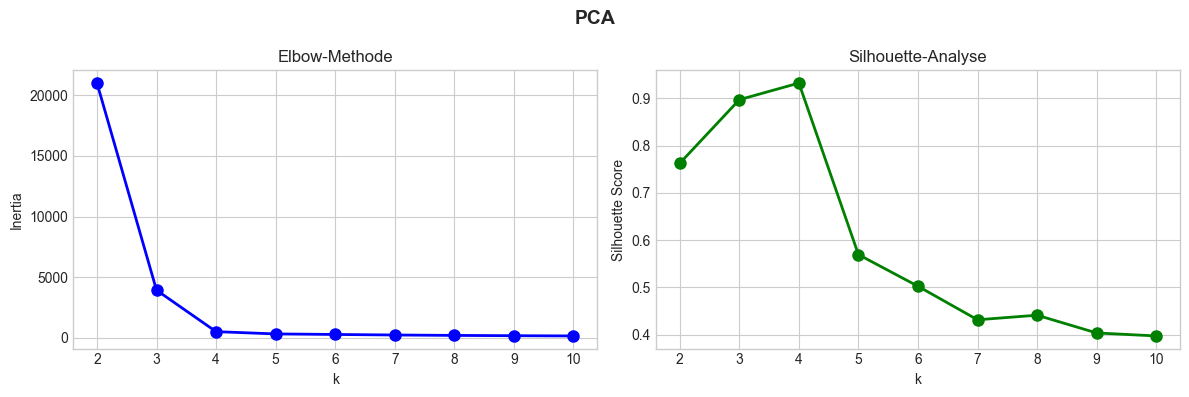

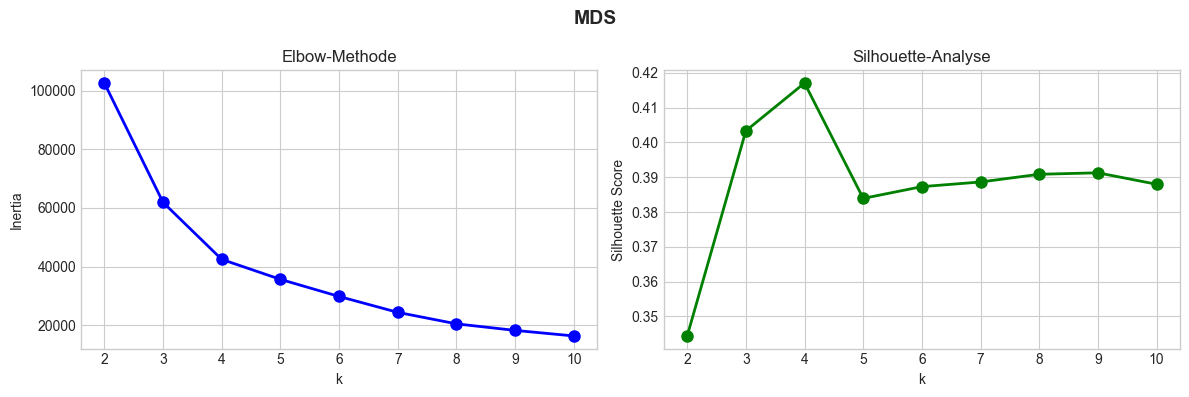

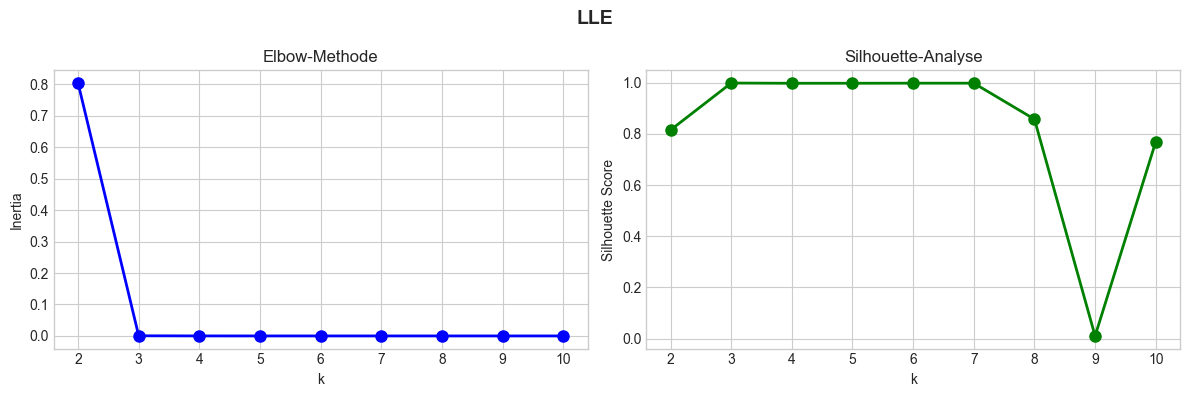

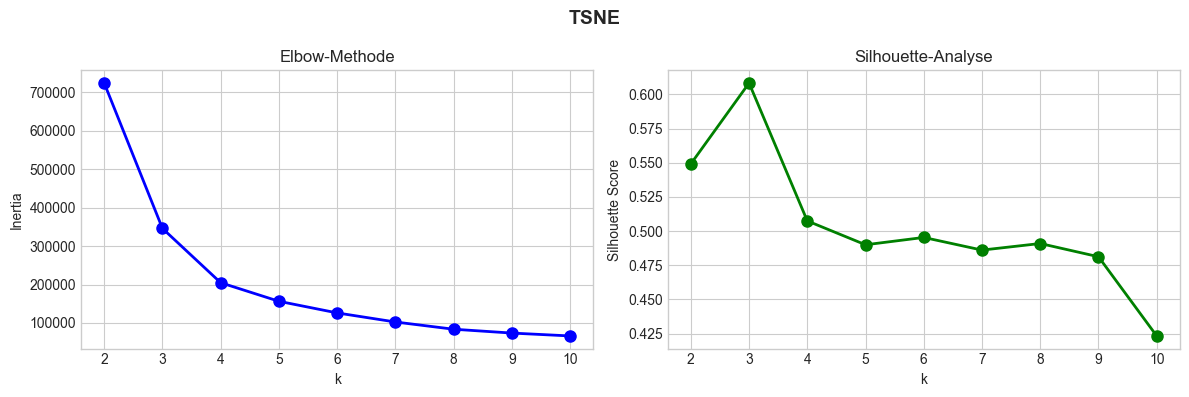

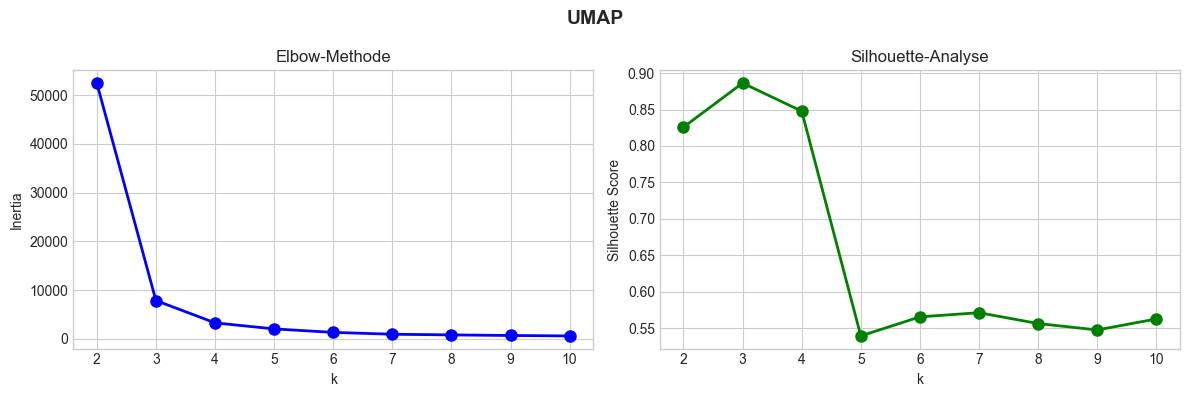

In [29]:
for method in methods:
    plot_cluster_evaluation(reduced_data[method].values, method)

## 3. k-Means Clustering

## 4. Gaussian Mixture Model (GMM) Clustering

## 5. Hierarchisches Clustering

## 6. Vergleich der Clustering-Methoden

## 7. Ergebnisse speichern